In [1]:
import os
import glob
import json
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from umap import UMAP
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import matplotlib.colors as mplcolors
import seaborn as sns
from antropy import lziv_complexity
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from itertools import combinations

c:\Users\pthoe\miniconda3\envs\gpt\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\pthoe\miniconda3\envs\gpt\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\pthoe\miniconda3\envs\gpt\lib\site-packages\umap\distances.py:1086: NumbaDeprecatio

# Automated model list and coloring

In [2]:
def get_data_locations(genre, vecs=True):
    if vecs:
        path_pattern = f"../machine_data_stories/final/embeddings/*_{genre}_*.json"
    else:
        path_pattern = f"../machine_data_stories/final/*{genre}*.json"
    filenames = glob.glob(path_pattern)

    data_locations = {}
    for filename in filenames:
        basename = os.path.basename(filename)
        no_ext = os.path.splitext(basename)[0]

        parts = no_ext.split('_')
        model = parts[0]

        if model.lower() != 'human':
            temp = parts[1].replace('temp', '')
            key = f"{model} (temp {temp})"
        else:
            key = model
        
        if key in data_locations:
            data_locations[key].append(filename)
        else:
            data_locations[key] = [filename]
    return data_locations


def parse_temp(filename):
    if 'temp' in filename:
        return float(filename.split('temp ')[1].replace(")", ""))
    return 1.0
    

def color_generator(data_locations, **model_colors):
    models = sorted(set(name.split(' ')[0] for name in data_locations.keys()))
    missing_models = [model for model in models if model not in model_colors]
    assert not missing_models, f"Base color for the following models is missing: {', '.join(missing_models)}"
    
    color_dict = {}
    for name in data_locations.keys():
        model = name.split(' ')[0]
        
        max_temp = max(parse_temp(name) for name in data_locations.keys() if model in name)
        temp = parse_temp(name) / max_temp

        base_color = mplcolors.to_rgb(model_colors[model])
        interp_color = [base_color[i] * temp for i in range(3)]
        
        color_code = mplcolors.rgb2hex(interp_color)
        color_dict[name] = color_code
    return [color_dict[name] for name in data_locations.keys()]

# Dimensionality Reduction Plots

In [3]:
def plot_embedding(data, data_name, embedding_type="tSNE", colors=None, kde=False, title=True, legend=True, show=True):
    vecs_all = np.concatenate(list(data.values()))
    model_ids = np.concatenate([[i] * len(vecs) for i, vecs in enumerate(data.values())])

    if embedding_type.lower() == "tsne":
        emb = TSNE(n_components=2)
    elif embedding_type.lower() == "pca":
        emb = PCA(n_components=2)
    elif embedding_type.lower() == "umap":
        emb = UMAP(n_components=2)
    else:
        raise ValueError(f"Unknown embedding type {embedding_type}")

    emb_vecs = emb.fit_transform(vecs_all)

    if title:
        plt.title(f"{embedding_type} embedding ({data_name})")

    for i, name in enumerate(data.keys()):
        cluster_data = emb_vecs[model_ids == i].T
        c = colors[i] if colors is not None else f"C{i}"
        plt.scatter(*cluster_data, label=name, alpha=0.8, s=40, c=c, edgecolors='black', linewidths=0.5)

        if kde:
            sns.kdeplot(x=cluster_data[0], y=cluster_data[1], fill=True, color=c, alpha=0.1, thresh=0.01, levels=2)

    plt.axis("off")
    if legend:
        plt.legend()
    if show:
        plt.show()

In [4]:
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

def euclidean_distance(vec1, vec2):
    return np.linalg.norm(vec1 - vec2)

def plot_pairwise_similarity(data, data_name, metric="cosine", pca_comps=None, cmap="Blues", show=True):
    if metric.lower() == "cosine":
        metric_fn = cosine_similarity
    elif metric.lower() == "euclidean":
        metric_fn = euclidean_distance
    else:
        raise ValueError(f"Unknown metric {metric}")

    if pca_comps is not None:
        vecs_all = np.concatenate(list(data.values()))
        pca = PCA(n_components=pca_comps)
        pca.fit(vecs_all)
        data = {k: pca.transform(v) for k, v in data.items()}

    sim_matrix = np.zeros((len(data), len(data)))
    for idx1, model1 in enumerate(data.keys()):
        for idx2, model2 in enumerate(data.keys()):
            if idx1 < idx2:
                continue
            vecs1, vecs2 = data[model1], data[model2]

            similarities = []
            for i in range(vecs1.shape[0]):
                for j in range(i + 1, vecs2.shape[0]):
                    v1, v2 = vecs1[i], vecs2[j]
                    similarities.append(metric_fn(v1, v2))
            sim_matrix[idx1, idx2] = np.mean(similarities)
    
    pca_suffix = f" of {pca_comps} PCs" if pca_comps is not None else ""
    if metric.lower() == "cosine":
        plt.title(f"Pairwise cosine similarity{pca_suffix} ({data_name})")
    elif metric.lower() == "euclidean":
        plt.title(f"Pairwise euclidean distance{pca_suffix} ({data_name})")

    mask = np.triu(np.ones_like(sim_matrix), k=1)
    sns.heatmap(sim_matrix, annot=True, xticklabels=list(data.keys()), yticklabels=list(data.keys()), mask=mask, cmap=cmap)
    if show:
        plt.show()

In [5]:
def to_embedding_fname(fname):
    fname = fname.replace('.json', '_vecs.json')
    components = fname.split(os.sep)
    components.insert(-2, 'embeddings')
    return os.sep.join(components)


def load_data(data_locations, max_samples=100, fname_only=False, vecs=True):
    data = {}
    for name, locs in data_locations.items():
        curr = []
        for loc in locs:

            if fname_only:
                if vecs:
                    loc = os.path.join("..","machine_data_stories", "final", "embeddings", loc.replace('.json', '_vecs.json'))
                else:
                    loc = os.path.join("..","machine_data_stories", "final", "embeddings", loc)

            # load embedding vectors
            with open(loc, "r") as f:
                txt = json.load(f)
            curr.append(np.array(list(txt.values())))
        data[name] = np.concatenate(curr)[:max_samples]
    return data

def embedding_summary(data_locations, data_name, colors=None):
    data = load_data(data_locations)
    
    print(f"Number of samples per model ({data_name}):")
    for name, vecs in data.items():
        print("\t", name, vecs.shape[0])

    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plot_embedding(data, data_name, embedding_type="PCA", colors=colors, legend=False, show=False)
    plt.subplot(132)
    plot_embedding(data, data_name, embedding_type="tSNE", colors=colors, legend=False, show=False)
    plt.subplot(133)
    plot_embedding(data, data_name, embedding_type="UMAP", colors=colors, legend=False, show=False)
    plt.legend(loc="lower right", bbox_to_anchor=(0.2, 0))
    plt.show()

def pairwise_distance_summary(data_locations, data_name):
    data = load_data(data_locations)

    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plot_pairwise_similarity(data, data_name, metric="cosine", cmap="Blues", show=False)
    plt.subplot(122)
    plot_pairwise_similarity(data, data_name, metric="euclidean", pca_comps=2, cmap="Blues_r", show=False)
    plt.tight_layout()
    plt.show()

Number of samples per model (Flash Fiction):
	 GPT3 (temp 1.0) 100
	 GPT4 (temp 0.8) 100
	 GPT4 (temp 0.9) 100
	 GPT4 (temp 1.0) 100
	 GPT4 (temp 1.1) 100
	 GPT4 (temp 1.2) 100
	 Vicuna (temp 0.8) 100


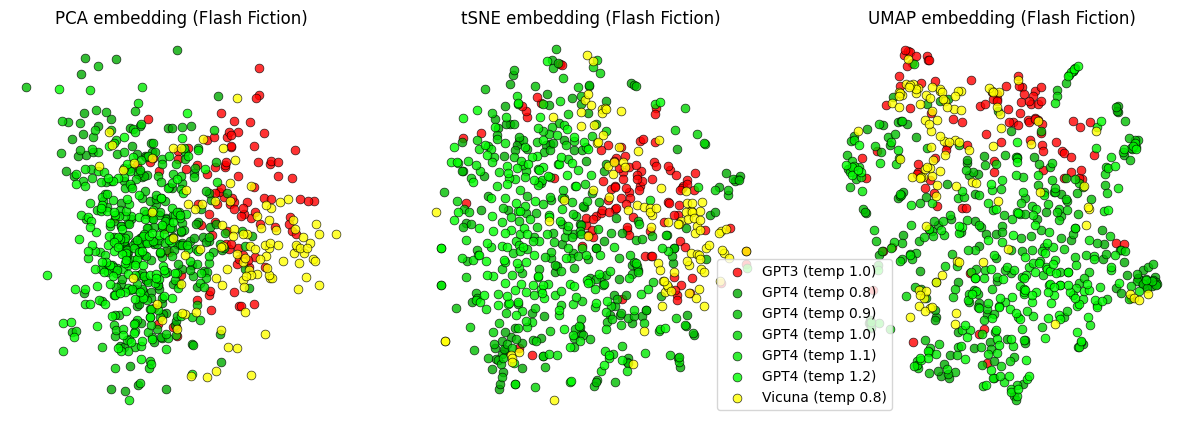

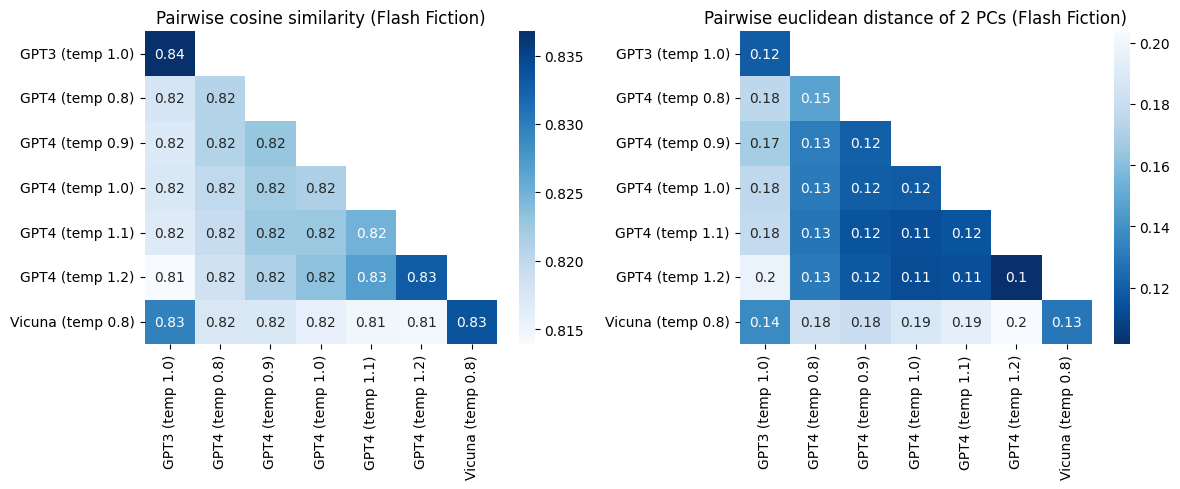

Number of samples per model (Haiku):
	 GPT3 (temp 1.0) 100
	 GPT4 (temp 0.6) 100
	 GPT4 (temp 0.8) 100
	 GPT4 (temp 1.0) 100
	 GPT4 (temp 1.2) 100
	 GPT4 (temp 1.4) 100
	 human 100
	 Vicuna (temp 0.8) 100


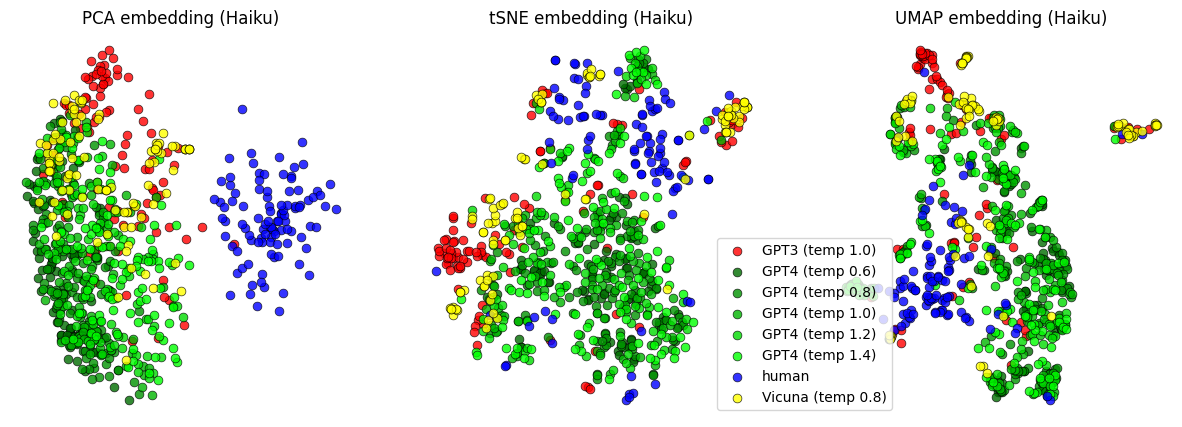

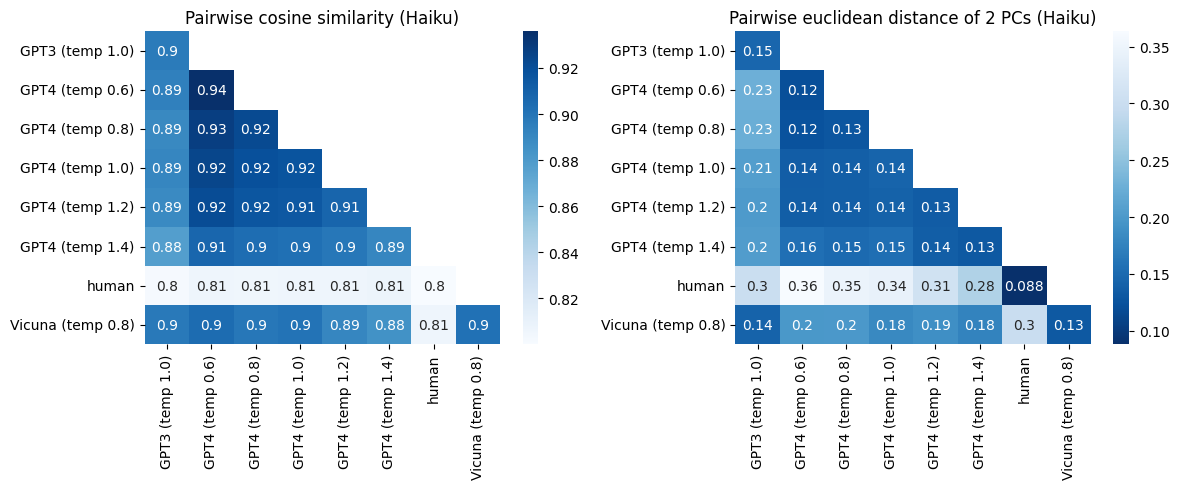

Number of samples per model (Synopsis):
	 GPT3 (temp 1.0) 100
	 GPT4 (temp 0.6) 100
	 GPT4 (temp 0.8) 100
	 GPT4 (temp 1.0) 100
	 GPT4 (temp 1.2) 100
	 GPT4 (temp 1.4) 100
	 Vicuna (temp 0.8) 100
	 human 100


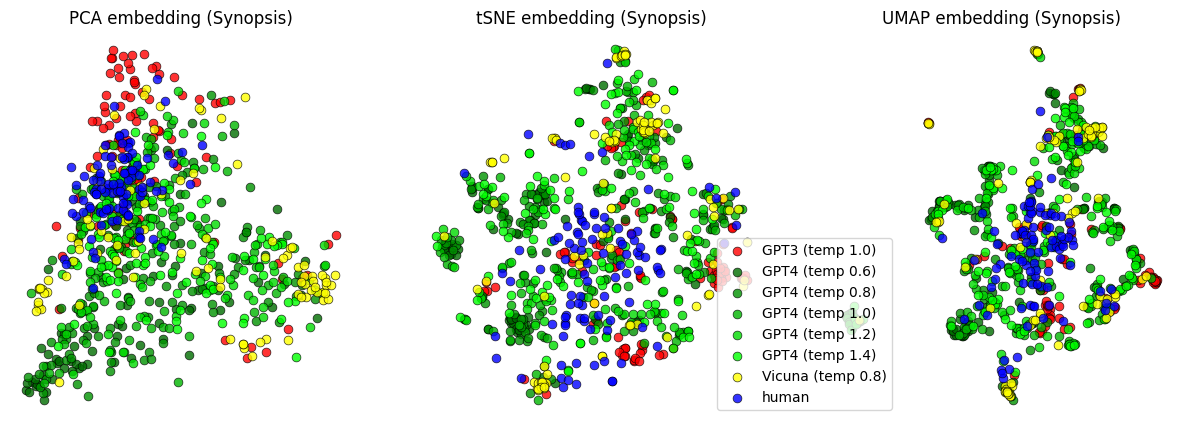

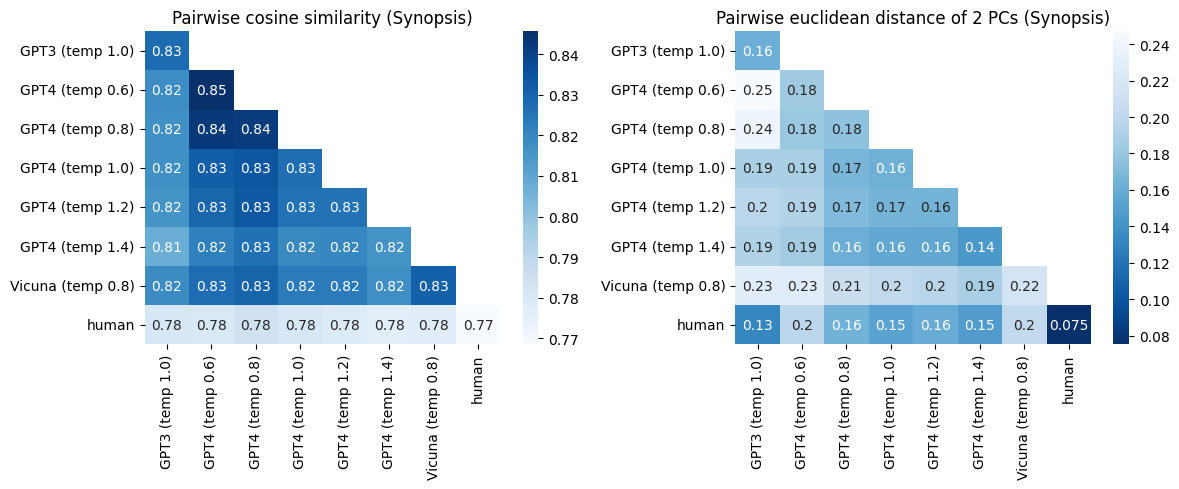

In [6]:
data_name = "Flash Fiction"
data_locations = get_data_locations("flash_fictions")
colors = color_generator(data_locations, GPT3="#ff0000", GPT4="#00ff00", Vicuna="#ffff00", Human="#0000ff")
embedding_summary(data_locations, data_name, colors=colors)
pairwise_distance_summary(data_locations, data_name)

data_name = "Haiku"
data_locations = get_data_locations("haikus")
colors = color_generator(data_locations, GPT3="#ff0000", GPT4="#00ff00", Vicuna="#ffff00", human="#0000ff")
embedding_summary(data_locations, data_name, colors=colors)
pairwise_distance_summary(data_locations, data_name)

data_name = "Synopsis"
data_locations = get_data_locations("synopses")
data_locations["human"] = ["../machine_data_stories/final/embeddings/TMDB_movies_subset_human_vecs.json"]
colors = color_generator(data_locations, GPT3="#ff0000", GPT4="#00ff00", Vicuna="#ffff00", human="#0000ff")
embedding_summary(data_locations, data_name, colors=colors)
pairwise_distance_summary(data_locations, data_name)

# PCA distribution of selected models on Haikus, Flash Fiction, and Synopses

In [7]:
model_colors = {"GPT-3": "#EF6C00", "GPT-4": "#3F51B5", "Vicuna": "#7BC8F6", "Human": "darkgrey"}

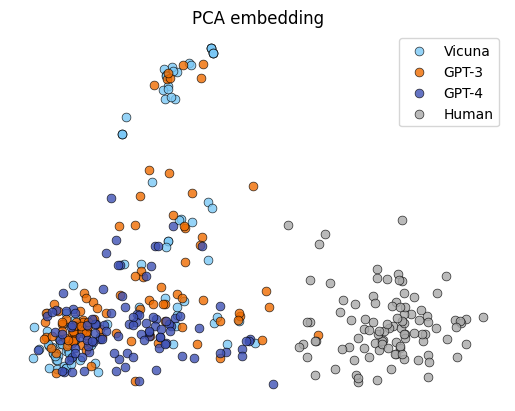

In [8]:
models = {
    "Vicuna": ["Vicuna_temp0.8_haikus.json"],
    "GPT-3": ["GPT3_temp1.0_haikus.json"],
    "GPT-4": ["GPT4_temp1.0_haikus.json"],
    "Human": ["human_haikus.json"]
}

vecs = load_data(models, fname_only=True, vecs=True)
plot_embedding(vecs, "Haiku", embedding_type="pca", colors=[model_colors[key] for key in models.keys()], title=False, show=False)
plt.title("PCA embedding")
plt.savefig("../figures/haiku_pca.png", dpi=300)

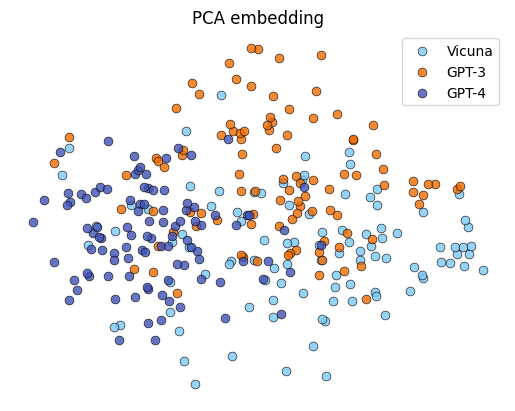

In [9]:
models = {
    "Vicuna": ["vicuna_temp0.8_flash_fictions.json"],
    "GPT-3": ["GPT3_temp1.0_flash_fictions.json"],
    "GPT-4": ["GPT4_temp1.0_flash_fictions.json"],
}

vecs = load_data(models, fname_only=True, vecs=True)
plot_embedding(vecs, "Flash Fiction", embedding_type="pca", colors=[model_colors[key] for key in models.keys()], title=False, show=False)
plt.title("PCA embedding")
plt.savefig("../figures/flash_fiction_pca.png", dpi=300)

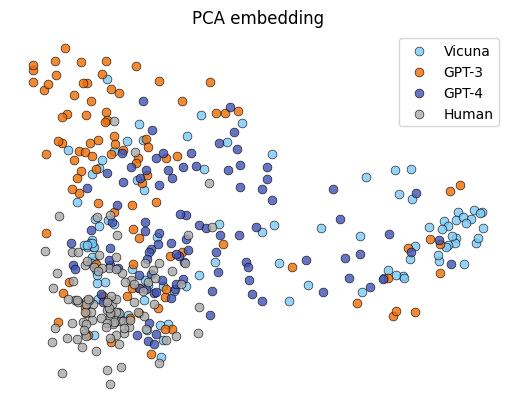

In [10]:
models = {
    "Vicuna": ["vicuna_temp0.8_synopses.json"],
    "GPT-3": ["GPT3_temp1.0_synopses.json"],
    "GPT-4": ["GPT4_temp1.0_synopses.json"],
    "Human": ["TMDB_movies_subset_human.json"],
}

vecs = load_data(models, fname_only=True, vecs=True)
plot_embedding(vecs, "Synopsis", embedding_type="pca", colors=[model_colors[key] for key in models.keys()], title=False, show=False)
plt.title("PCA embedding")
plt.savefig("../figures/synopsis_pca.png", dpi=300)

# Exploration of GPT-4 temperature on PCA distribution

In [11]:
from matplotlib.colors import to_rgb

def color_gradient(start, end, n):
    if isinstance(start, str):
        start = np.array(to_rgb(start))
    elif not isinstance(start, np.ndarray):
        start = np.array(start)
    if isinstance(end, str):
        end = np.array(to_rgb(end))
    elif not isinstance(end, np.ndarray):
        end = np.array(end)

    return [start + (end - start) * i / (n - 1) for i in range(n)]

C:\Users\pthoe\AppData\Local\Temp\ipykernel_12652\2990575396.py:22: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(*cluster_data, label=name, alpha=0.8, s=40, c=c, edgecolors='black', linewidths=0.5)


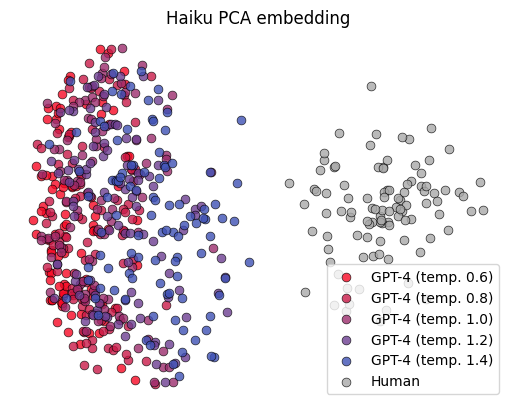

In [12]:
models = {
    "GPT-4 (temp. 0.6)": ["GPT4_temp0.6_haikus.json"],
    "GPT-4 (temp. 0.8)": ["GPT4_temp0.8_haikus.json"],
    "GPT-4 (temp. 1.0)": ["GPT4_temp1.0_haikus.json"],
    "GPT-4 (temp. 1.2)": ["GPT4_temp1.2_haikus.json"],
    "GPT-4 (temp. 1.4)": ["GPT4_temp1.4_haikus.json"],
    "Human": ["human_haikus.json"]
}

col = color_gradient("#F70824", model_colors["GPT-4"], len(models) - 1)
col.append(model_colors["Human"])

vecs = load_data(models, fname_only=True, vecs=True)
plot_embedding(vecs, "Haiku", embedding_type="pca", colors=col, title=False, show=False, legend=False)
plt.legend(loc="lower right")
plt.title("Haiku PCA embedding")
plt.savefig("../figures/haiku_pca_temp.png", dpi=300)

C:\Users\pthoe\AppData\Local\Temp\ipykernel_12652\2990575396.py:22: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(*cluster_data, label=name, alpha=0.8, s=40, c=c, edgecolors='black', linewidths=0.5)


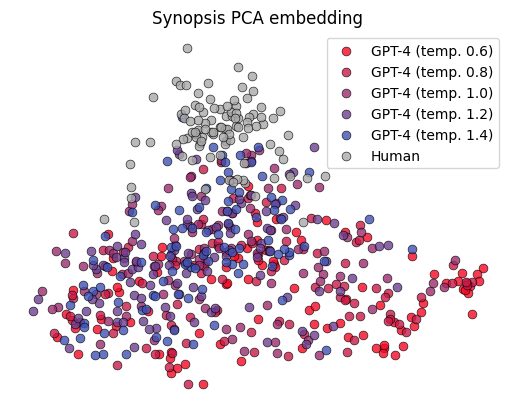

In [13]:
models = {
    "GPT-4 (temp. 0.6)": ["GPT4_temp0.6_synopses.json"],
    "GPT-4 (temp. 0.8)": ["GPT4_temp0.8_synopses.json"],
    "GPT-4 (temp. 1.0)": ["GPT4_temp1.0_synopses.json"],
    "GPT-4 (temp. 1.2)": ["GPT4_temp1.2_synopses.json"],
    "GPT-4 (temp. 1.4)": ["GPT4_temp1.4_synopses.json"],
    "Human": ["TMDB_movies_subset_human.json"]
}

col = color_gradient("#F70824", model_colors["GPT-4"], len(models) - 1)
col.append(model_colors["Human"])

vecs = load_data(models, fname_only=True, vecs=True)
plot_embedding(vecs, "Haiku", embedding_type="pca", colors=col, title=False, show=False, legend=False)
plt.legend(loc="upper right")
plt.title("Synopsis PCA embedding")
plt.savefig("../figures/synopsis_pca_temp.png", dpi=300)

# Lempel-Ziv complexity

In [14]:
def to_string(v):
    if isinstance(v, dict):
        return v["overview"]
    elif isinstance(v, str):
        return v
    else:
        raise ValueError("Invalid type")

def complexity_plot(data_locations, colors=None, max_stories=100, p_threshold=0.01, draw_stats=False, show=True):
    texts = {}
    for name, fnames in data_locations.items():
        for fname in fnames:
            try:
                with open(f"../machine_data_stories/final/{fname}", "r") as f:
                    curr = json.load(f)
            except FileNotFoundError:
                with open(fname, "r") as f:
                    curr = json.load(f)
            curr = curr if isinstance(curr, list) else list(curr.values())
            if name in texts:
                texts[name].extend(curr)
            else:
                texts[name] = curr
        if len(texts[name]) > max_stories:
            texts[name] = texts[name][:max_stories]

    complexities = []
    for name, text in texts.items():
        scores = [lziv_complexity(to_string(t), normalize=True) for t in text]
        complexities.append(scores)

    if isinstance(colors, dict):
        colors = [colors[name] for name in data_locations.keys()]

    plt.title(f"Lempel-Ziv complexity")
    # remove black outline
    sns.violinplot(data=[np.array(c) for c in complexities], palette=colors, linewidth=1)
    plt.xticks(range(len(complexities)), list(data_locations.keys()), rotation=45, ha="right")

    if draw_stats:
        p_values = []
        for i in range(len(complexities)):
            for j in range(i+1, len(complexities)):
                t_stat, p_val = ttest_ind(complexities[i], complexities[j])
                p_values.append(p_val)
        
        reject, corrected_p_values, _, _ = multipletests(p_values, method='fdr_bh', alpha=p_threshold)

        # Initialize maximum Y value for brackets
        y_max = 0

        # Draw brackets for significance
        for i, (x1, x2) in enumerate(combinations(range(len(complexities)), 2)):
            if reject[i]:
                # Define bracket height and offset
                y, h, col = max(max(complexities[x1]), max(complexities[x2])) + 0.02, 0.02, 'k'
                if y <= y_max:  # If the starting point of the bracket is lower than the previous max, shift it up
                    y = y_max + 0.03
                y_max = y + h  # Update maximum Y value
                plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, color=col)  # Draw the bracket
                plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)  # Mark with asterisk
    
    if show:
        plt.show()

Text(0.5, 1.0, 'Lempel-Ziv complexity (Synopsis)')

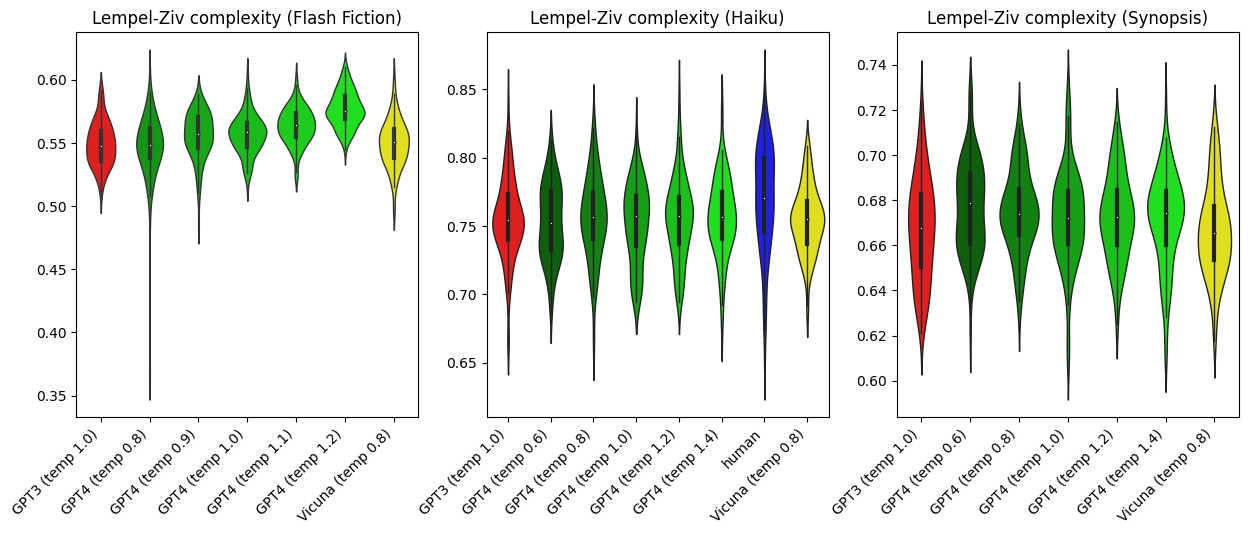

In [15]:
plt.figure(figsize=(15, 5))

# flash fiction
fnames = get_data_locations("flash_fictions", vecs=False)
colors = color_generator(fnames, GPT3="#ff0000", GPT4="#00ff00", Vicuna="#ffff00", human="#0000ff")
plt.subplot(1, 3, 1)
complexity_plot(fnames, colors=colors, show=False)
plt.title("Lempel-Ziv complexity (Flash Fiction)")

# flash_fiction
fnames = get_data_locations("haikus", vecs=False)
colors = color_generator(fnames, GPT3="#ff0000", GPT4="#00ff00", Vicuna="#ffff00", human="#0000ff")
plt.subplot(1, 3, 2)
complexity_plot(fnames, colors=colors, show=False)
plt.title("Lempel-Ziv complexity (Haiku)")

# synopsis
fnames = get_data_locations("synopses", vecs=False)
colors = color_generator(fnames, GPT3="#ff0000", GPT4="#00ff00", Vicuna="#ffff00", human="#0000ff")
plt.subplot(1, 3, 3)
complexity_plot(fnames, colors=colors, show=False)
plt.title("Lempel-Ziv complexity (Synopsis)")

# Comparison of Haiku embeddings to the word "nature"

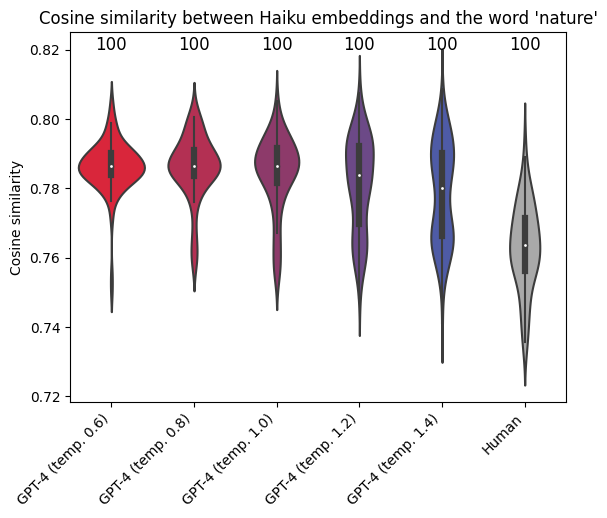

In [16]:
with open("../machine_data_stories/final/embeddings/nature_vec.json", "r") as f:
    nature_vec = np.array(json.load(f))

models = {
    "GPT-4 (temp. 0.6)": "GPT4_temp0.6_haikus_vecs.json",
    "GPT-4 (temp. 0.8)": "GPT4_temp0.8_haikus_vecs.json",
    "GPT-4 (temp. 1.0)": "GPT4_temp1.0_haikus_vecs.json",
    "GPT-4 (temp. 1.2)": "GPT4_temp1.2_haikus_vecs.json",
    "GPT-4 (temp. 1.4)": "GPT4_temp1.4_haikus_vecs.json",
    "Human": "human_haikus_vecs.json"
}

# load data
model_vecs = {}
for model in models:
    with open("../machine_data_stories/final/embeddings/" + models[model], "r") as f:
        model_vecs[model] = np.array(list(json.load(f).values()))

# calculate cosine similarities
distances = {}
for model in model_vecs:
    distances[model] = np.array([cosine_similarity(nature_vec, vec) for vec in model_vecs[model]])

def show_distr(distances, indices=None, y=0.82, title="Cosine similarity between Haiku embeddings and the word 'nature'"):
    # create color gradient
    col = color_gradient("#F70824", model_colors["GPT-4"], len(models) - 1)
    col.append(model_colors["Human"])

    # optionally filter distances
    if indices is not None:
        filter_fn = lambda x, key: x[indices[key]] if key in indices else x
        distances = {key: filter_fn(distances[key], key) for key in distances}

    # show results using violin plots
    ax = sns.violinplot(data=list(distances.values()), palette=col)
    # write numer of samples above each violin plot
    for i, key in enumerate(distances):
        ax.text(i, y, str(len(distances[key])), horizontalalignment="center", fontsize=12)

    plt.xticks(range(len(models)), list(models.keys()), rotation=45, ha="right")
    plt.ylabel("Cosine similarity")
    plt.title(title)
    plt.show()

show_distr(distances)

#### Extract indices of Haikus with human-like distance to the word "nature"

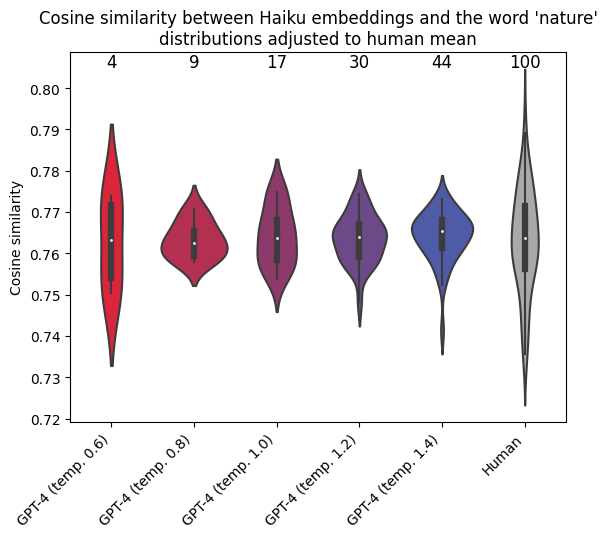

In [17]:
threshold = 0.012

human_mean = distances["Human"].mean()

indices = {}
for model in distances.keys():
    if model == "Human":
        continue
    indices[model] = np.where((distances[model] - human_mean) < threshold)[0]

show_distr(distances, indices, y=0.805, title="Cosine similarity between Haiku embeddings and the word 'nature'\ndistributions adjusted to human mean")

#### Compute LZc of GPT Haikus with similar "nature" distribution as human Haikus

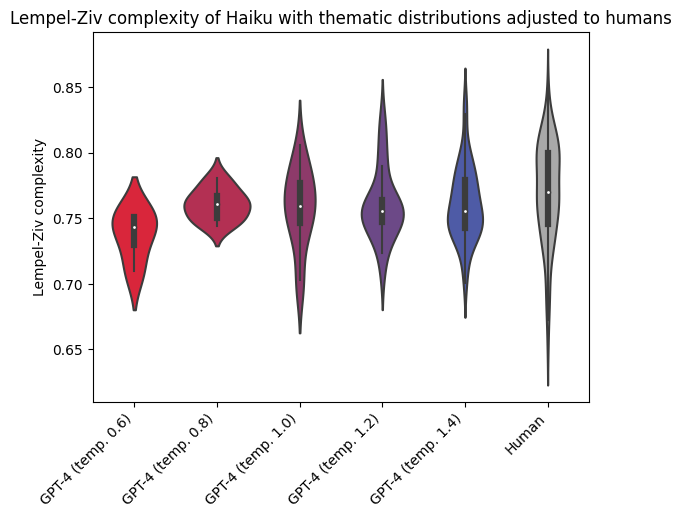

In [18]:
texts = {}
for model, fname in models.items():
    with open("../machine_data_stories/final/" + fname.replace("_vecs", ""), "r") as f:
        text = np.array(list(json.load(f).values()))
    texts[model] = text[indices[model]] if model in indices else text

complexities = {}
for name, text in texts.items():
    scores = [lziv_complexity(to_string(t), normalize=True) for t in text]
    complexities[name] = np.array(scores)

sns.violinplot(data=list(complexities.values()), palette=col)
plt.xticks(range(len(complexities)), list(complexities.keys()), rotation=45, ha="right")
plt.ylabel("Lempel-Ziv complexity")
plt.title("Lempel-Ziv complexity of Haiku with thematic distributions adjusted to humans")
plt.show()